# ==============================
# 📈 LSTM Stock Price Prediction (PLTR)
# ==============================


In [2]:
!pip install yfinance

In [3]:
# Step 1. Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [4]:
# Step 2. Download PLTR data
ticker = 'PLTR'
data = yf.download(ticker, start='2020-01-01', end='2025-10-01')
print("Data shape:", data.shape)
data.tail()

/var/folders/9v/9dcjztmd5kxffqw73qlg37l40000gn/T/ipykernel_57037/2921085502.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start='2020-01-01', end='2025-10-01')
[*********************100%***********************]  1 of 1 completed

Data shape: (1256, 5)


Price,Close,High,Low,Open,Volume
Ticker,PLTR,PLTR,PLTR,PLTR,PLTR
Date,,,,,
2025-09-24,179.559998,184.850006,177.119995,183.910004,45379700
2025-09-25,179.119995,184.320007,174.289993,175.800003,72321200
2025-09-26,177.570007,180.119995,174.910004,179.050003,44275800
2025-09-29,178.860001,181.479996,177.160004,179.639999,38413800
2025-09-30,182.419998,182.770004,178.220001,178.979996,43561700


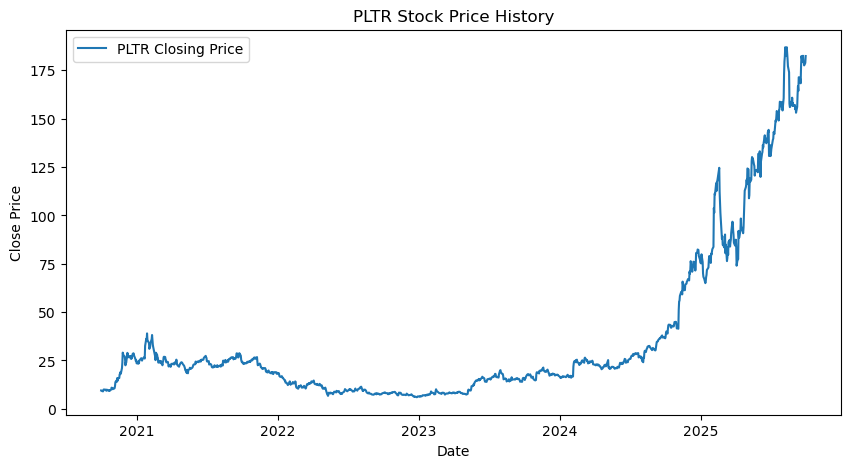

In [5]:
# Step 3. Prepare closing price data
close_data = data[['Close']]
plt.figure(figsize=(10,5))
plt.plot(close_data, label='PLTR Closing Price')
plt.title('PLTR Stock Price History')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [6]:
# Step 4. Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_data)

In [7]:
# Step 5. Train-test split (80/20)
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size - 60:]

In [8]:
# Step 6. Create sequences for LSTM
def create_sequences(dataset, time_step=60):
    X, y = [], []
    for i in range(time_step, len(dataset)):
        X.append(dataset[i-time_step:i, 0])
        y.append(dataset[i, 0])
    return np.array(X), np.array(y)

time_step = 60
X_train, y_train = create_sequences(train_data, time_step)
X_test, y_test = create_sequences(test_data, time_step)

In [9]:
# Reshape input for LSTM [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (944, 60, 1)
X_test shape: (252, 60, 1)


In [10]:
# Step 7. Build LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_step, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

/opt/miniconda3/envs/ztdltest/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Step 8. Train model
history = model.fit(X_train, y_train, batch_size=64, epochs=20, validation_split=0.1, verbose=1)

Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 2.8886e-04 - val_loss: 3.8409e-04
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1.6774e-04 - val_loss: 3.6482e-04
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1.5009e-04 - val_loss: 2.1765e-04
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1.2852e-04 - val_loss: 1.3829e-04
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 1.0948e-04 - val_loss: 1.9117e-04
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1.2073e-04 - val_loss: 1.7145e-04
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 1.1728e-04 - val_loss: 1.5040e-04
Epoch 9/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 1.0563e-04 - val_loss: 2.7426e-04
Epoch 10/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1.2320e-04 - val_loss: 1.0624e-04
Epoch 11/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1.0830e-04 - val_

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


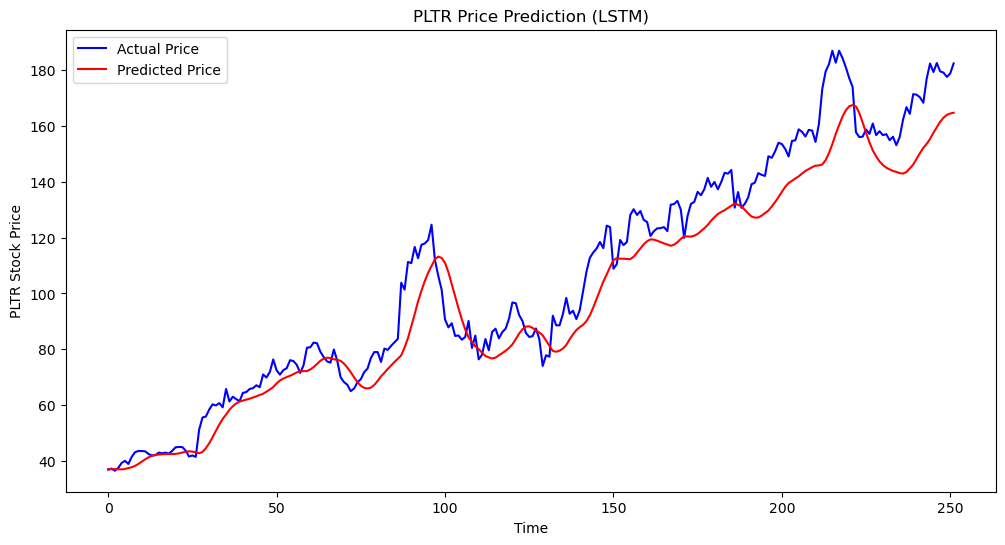

In [12]:
# Step 9. Predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Step 10. Visualization
plt.figure(figsize=(12,6))
plt.plot(y_test_actual, label='Actual Price', color='blue')
plt.plot(predictions, label='Predicted Price', color='red')
plt.title('PLTR Price Prediction (LSTM)')
plt.xlabel('Time')
plt.ylabel('PLTR Stock Price')
plt.legend()
plt.show()

In [13]:
# Step 11. Evaluate
rmse = np.sqrt(np.mean((predictions - y_test_actual)**2))
print("RMSE:", rmse)


RMSE: 11.92028376741075


In [14]:
# Step 12. Predict next day price
last_60_days = scaled_data[-60:]
X_future = np.array([last_60_days])
X_future = X_future.reshape((X_future.shape[0], X_future.shape[1], 1))

next_day_scaled = model.predict(X_future)
next_day_price = scaler.inverse_transform(next_day_scaled)
print(f"Predicted next day closing price for PLTR: ${next_day_price[0][0]:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted next day closing price for PLTR: $165.10
